# Preferential Bayesian Optimization: EI
This notebook demonstrates the use of the Expected Improvement (EI) acquisition function on ordinal (preference) data.

Formulation by Nguyen Quoc Phong.

In [1]:
import numpy as np
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import os
import pickle

from gpflow.utilities import set_trainable, print_summary
gpflow.config.set_default_summary_fmt("notebook")

sys.path.append(os.path.split(os.path.split(os.path.split(os.getcwd())[0])[0])[0]) # Move 3 levels up directory to import PBO
import PBO

In [2]:
objective = PBO.objectives.forrester
objective_low = 0.
objective_high = 1.
objective_name = "Forrester"
acquisition_name = "EI"
experiment_name = "PBO" + "_" + acquisition_name + "_" + objective_name

In [3]:
num_runs = 20
num_evals = 20
num_samples = 100
num_choices = 2
input_dims = 1
num_maximizers = 20
num_init_points = 3
num_inducing_init = 3
num_discrete_per_dim = 10000 # Discretization of continuous input space

In [4]:
results_dir = os.getcwd() + '/results/' + experiment_name + '/'

try:
    # Create target Directory
    os.makedirs(results_dir)
    print("Directory " , results_dir ,  " created ") 
except FileExistsError:
    print("Directory " , results_dir ,  " already exists")

Directory  /home/sebtsh/PBO/notebooks/EI/results/PBO_EI_Forrester/  created 


Plot of the Forrester function (global min at ~0.757):

(-0.0, 1.0)

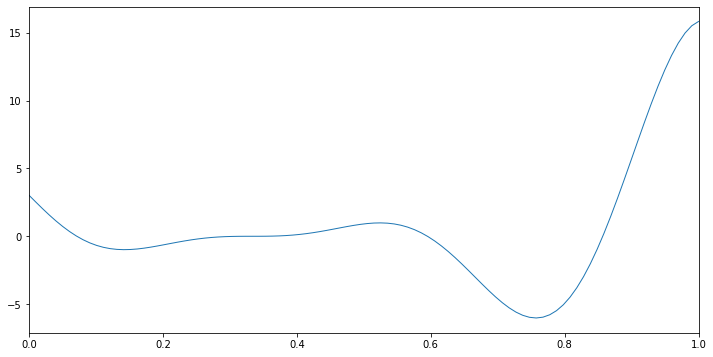

In [5]:
xx = np.linspace(0.0, 1.0, 100).reshape(100, 1)
plt.figure(figsize=(12, 6))
plt.plot(xx, objective(xx), 'C0', linewidth=1)
plt.xlim(-0.0, 1.0)

In [6]:
def plot_gp(model, X, y, title, cmap="Spectral"):
    #Plotting code from GPflow authors

    ## generate test points for prediction
    xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

    ## predict mean and variance of latent GP at test points
    mean, var = model.predict_f(xx)

    ## generate 10 samples from posterior
    samples = model.predict_f_samples(xx, 10)  # shape (10, 100, 1)

    ## plot 
    plt.figure(figsize=(12, 6))
    plt.plot(X, y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                     mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)

    plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
    plt.xlim(-0.1, 1.1)
    plt.title(title)

    plt.savefig(fname=results_dir + title + ".png")

In [7]:
def get_noisy_observation(X, objective):
    f = PBO.objectives.objective_get_f_neg(X, objective)
    return PBO.observation_model.gen_observation_from_f(X, f, 1)

In [8]:
def train_and_visualize(X, y, num_inducing, title):
    
    # Train model with data
    q_mu, q_sqrt, u, inputs, k, indifference_threshold = PBO.models.learning_stochastic.train_model_fullcov(X, y, 
                                                                         num_inducing=num_inducing,
                                                                         obj_low=objective_low,
                                                                         obj_high=objective_high,
                                                                         lengthscale=0.05,
                                                                         num_steps=3000)
    likelihood = gpflow.likelihoods.Gaussian()
    model = PBO.models.learning.init_SVGP_fullcov(q_mu, q_sqrt, u, k, likelihood)
    u_mean = q_mu.numpy()
    inducing_vars = u.numpy()
    
    # Visualize model
    plot_gp(model, inducing_vars, u_mean, title)
    
    return model, inputs, u_mean, inducing_vars

In [9]:
def uniform_grid(input_dims, num_discrete_per_dim, low=0., high=1.):
    """
    Returns an array with all possible permutations of discrete values in input_dims number of dimensions.
    :param input_dims: int
    :param num_discrete_per_dim: int
    :param low: int
    :param high: int
    :return: tensor of shape (num_discrete_per_dim ** input_dims, input_dims)
    """
    num_points = num_discrete_per_dim ** input_dims
    out = np.zeros([num_points, input_dims])
    discrete_points = np.linspace(low, high, num_discrete_per_dim)
    for i in range(num_points):
        for dim in range(input_dims):
            val = num_discrete_per_dim ** (dim)
            out[i, dim] = discrete_points[int((i // val) % num_discrete_per_dim)]
    return out

This function is our main metric for the performance of the acquisition function: The closer the model's best guess to the target (in this case, the global minimum of the Forrester function), the better.

In [10]:
def best_guess(model):
    """
    :return: tensor of shape (input_dims) a GP model's best guess of the global maximum of f.
    """
    xx = uniform_grid(input_dims, num_discrete_per_dim, low=objective_low, high=objective_high)
    res = model.predict_f(xx)[0].numpy()
    return xx[np.argmax(res)]

Store the results in these arrays:

In [11]:
num_data_at_end = int((num_init_points-1) * num_init_points / 2 + num_evals)
X_results = np.zeros([num_runs, num_data_at_end, num_choices, input_dims])
y_results = np.zeros([num_runs, num_data_at_end, 1, input_dims])
best_guess_results = np.zeros([num_runs, num_evals, input_dims])

Create the initial values for each run:

In [12]:
np.random.seed(0)
init_points = np.random.uniform(low=objective_low, high=objective_high, size=[num_runs, num_init_points, input_dims])
num_combs = int((num_init_points-1) * num_init_points / 2)
init_vals = np.zeros([num_runs, num_combs, num_choices, input_dims])
for run in range(num_runs):
    cur_idx = 0
    for init_point in range(num_init_points-1):
        for next_point in range(init_point+1, num_init_points):
            init_vals[run, cur_idx, 0] = init_points[run, init_point]
            init_vals[run, cur_idx, 1] = init_points[run, next_point]
            cur_idx += 1

In [14]:
y_results = np.zeros([num_runs, num_data_at_end, 1, input_dims])  # REMOVE LATER

In [15]:
X_results[0] = X
y_results[0] = y

The following loops carry out the Bayesian optimization algorithm over a number of runs, with a fixed number of evaluations per run.

In [ ]:
for run in range(1, num_runs):
    print("Beginning run %s" % (run))
    
    X = init_vals[run]
    y = get_noisy_observation(X, objective)
    
    model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, num_inducing_init, "Run_{}:_Initial_model".format(run))

    for evaluation in range(num_evals):
        print("Beginning evaluation %s" % (evaluation)) 

        # Get incumbent maximizer
        maximizer = np.expand_dims(best_guess(model), axis=0)  # (1, input_dims)
        
        print("Maximizer:")
        print(maximizer)
        
        # Sample possible next input points. In EI, all queries are a pair with the incumbent maximizer as the 
        # first point and a next input point as the second point
        
        samples = np.random.uniform(low=objective_low,
                                    high=objective_high,
                                    size=(num_samples, input_dims))
        
        # Calculate EI vals
        ei_vals = PBO.acquisitions.ei.EI(model, maximizer, samples)
        
        # Select query that maximizes EI
        next_idx = np.argmax(ei_vals)
        next_query = np.zeros((num_choices, input_dims))
        next_query[0, :] = maximizer  # EI only works in binary choices
        next_query[1, :] = samples[next_idx]
        print("Evaluation %s: Next query is %s with EI value of %s" % (evaluation, next_query, ei_vals[next_idx]))

        X = np.concatenate([X, [next_query]])
        # Evaluate objective function
        y = np.concatenate([y, get_noisy_observation(np.expand_dims(next_query, axis=0), objective)], axis=0)
        
        print("Evaluation %s: Training model" % (evaluation))
        model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, 
                                                                   num_inducing_init + evaluation + 1, 
                                                                   "Run_{}_Evaluation_{}".format(run, evaluation))

        best_guess_results[run, evaluation, :] = best_guess(model)

    X_results[run] = X
    y_results[run] = y

Beginning run 1
Indifference_threshold is trainable.
Negative ELBO at step 0: 3.0441605119999733 in 0.1671s
Negative ELBO at step 500: 2.312846300947608 in 51.2188s
Negative ELBO at step 1000: 2.2095987280855827 in 48.9825s
Negative ELBO at step 1500: 2.176299001088539 in 52.3910s
Negative ELBO at step 2000: 2.144275068762941 in 54.2437s
Negative ELBO at step 2500: 2.140021945070105 in 52.6269s
Beginning evaluation 0
Maximizer:
[[0.80228023]]
Evaluation 0: Next query is [[0.80228023]
 [0.81029076]] with EI value of [0.26819441]
Evaluation 0: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 3.6645806986298237 in 0.1712s
Negative ELBO at step 500: 3.2043907040805752 in 62.4460s
Negative ELBO at step 1000: 2.938898158985798 in 63.1277s
Negative ELBO at step 1500: 2.924658296022964 in 64.3577s
Negative ELBO at step 2000: 2.887015211553018 in 64.4959s
Negative ELBO at step 2500: 2.944703097079973 in 65.5565s
Beginning evaluation 1
Maximizer:
[[0.69276928]]
Evalua

Negative ELBO at step 0: 5929.560327357627 in 0.6354s
Negative ELBO at step 500: 30.62483975408727 in 222.8759s
Negative ELBO at step 1000: 20.866531843144188 in 222.9823s
Negative ELBO at step 1500: 16.14926034972592 in 224.7343s
Negative ELBO at step 2000: 14.164664136342521 in 222.8597s
Negative ELBO at step 2500: 13.500578773771686 in 220.8924s
Beginning evaluation 15
Maximizer:
[[0.65906591]]
Evaluation 15: Next query is [[0.65906591]
 [0.66485748]] with EI value of [0.30231393]
Evaluation 15: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 2306216.542134884 in 0.8181s
Negative ELBO at step 500: 5035.711543992775 in 234.2115s
Negative ELBO at step 1000: 2654.3790899029477 in 233.9078s
Negative ELBO at step 1500: 2003.548613205573 in 236.7559s
Negative ELBO at step 2000: 1009.2223784643226 in 230.9883s
Negative ELBO at step 2500: 824.436710481462 in 237.9654s
Beginning evaluation 16
Maximizer:
[[0.66156616]]
Evaluation 16: Next query is [[0.66156616]
 [

/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning run 2
Indifference_threshold is trainable.
Negative ELBO at step 0: 3.048953822121107 in 0.1506s
Negative ELBO at step 500: 2.1352246041525453 in 51.9370s
Negative ELBO at step 1000: 2.063347830815487 in 54.5576s
Negative ELBO at step 1500: 1.9307239735669046 in 53.8402s
Negative ELBO at step 2000: 1.88119652956471 in 52.1658s
Negative ELBO at step 2500: 1.8209874612982002 in 53.7147s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 0
Maximizer:
[[0.4170417]]
Evaluation 0: Next query is [[0.4170417 ]
 [0.42200646]] with EI value of [0.36473402]
Evaluation 0: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 3.496264506987028 in 0.1688s
Negative ELBO at step 500: 2.89608917353889 in 64.0369s
Negative ELBO at step 1000: 2.700534253901139 in 65.9179s
Negative ELBO at step 1500: 2.6121487048232597 in 64.0078s
Negative ELBO at step 2000: 2.5159112281668756 in 63.8930s
Negative ELBO at step 2500: 2.5397564386876397 in 64.9430s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 1
Maximizer:
[[0.4340434]]
Evaluation 1: Next query is [[0.4340434 ]
 [0.43171166]] with EI value of [0.37066463]
Evaluation 1: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 4.817927343833289 in 0.2479s
Negative ELBO at step 500: 3.762746814274069 in 78.2834s
Negative ELBO at step 1000: 3.450833223958411 in 74.5557s
Negative ELBO at step 1500: 3.6252366784488492 in 75.5745s
Negative ELBO at step 2000: 3.257225777526768 in 74.9055s
Negative ELBO at step 2500: 3.317121063481776 in 76.4840s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 2
Maximizer:
[[0.44194419]]
Evaluation 2: Next query is [[0.44194419]
 [0.44135762]] with EI value of [0.3243083]
Evaluation 2: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 6.2158107638915086 in 0.2214s
Negative ELBO at step 500: 4.146370176246992 in 87.1548s
Negative ELBO at step 1000: 4.019429659180312 in 86.7074s
Negative ELBO at step 1500: 3.9806296935626455 in 87.1359s
Negative ELBO at step 2000: 3.978084987551302 in 87.0378s
Negative ELBO at step 2500: 4.0038552288835305 in 88.3958s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 3
Maximizer:
[[0.43744374]]
Evaluation 3: Next query is [[0.43744374]
 [0.42052616]] with EI value of [0.36527255]
Evaluation 3: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 5.940805781236391 in 0.3014s
Negative ELBO at step 500: 4.856891833391415 in 99.2516s
Negative ELBO at step 1000: 4.663880344186635 in 97.0287s
Negative ELBO at step 1500: 4.660210389511243 in 99.8701s
Negative ELBO at step 2000: 4.6263743036060525 in 99.8237s
Negative ELBO at step 2500: 4.64946805025375 in 98.2553s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 4
Maximizer:
[[0.42694269]]
Evaluation 4: Next query is [[0.42694269]
 [0.43002707]] with EI value of [0.36330067]
Evaluation 4: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 8.358318281814023 in 0.2664s
Negative ELBO at step 500: 5.39741623806418 in 110.3303s
Negative ELBO at step 1000: 5.477754821426092 in 109.4266s
Negative ELBO at step 1500: 5.394555011573759 in 107.1878s
Negative ELBO at step 2000: 5.473055781131007 in 111.2680s
Negative ELBO at step 2500: 5.39375470274599 in 109.8595s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 5
Maximizer:
[[0.42634263]]
Evaluation 5: Next query is [[0.42634263]
 [0.42889839]] with EI value of [0.35281771]
Evaluation 5: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 88.20546601797953 in 0.3558s
Negative ELBO at step 500: 6.431786751440503 in 121.8155s
Negative ELBO at step 1000: 6.22176310950133 in 119.9612s
Negative ELBO at step 1500: 6.103761659823976 in 123.1918s
Negative ELBO at step 2000: 6.1070217361659465 in 119.8368s
Negative ELBO at step 2500: 6.16245569623105 in 123.2385s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 6
Maximizer:
[[0.430043]]
Evaluation 6: Next query is [[0.430043  ]
 [0.42206959]] with EI value of [0.35436088]
Evaluation 6: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 44787.66127900263 in 0.4286s
Negative ELBO at step 500: 148.0793537795613 in 132.7707s
Negative ELBO at step 1000: 46.48339732141196 in 130.1132s
Negative ELBO at step 1500: 36.583257306904606 in 135.3954s
Negative ELBO at step 2000: 24.70146702518551 in 133.2973s
Negative ELBO at step 2500: 18.82185585996565 in 133.9214s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 7
Maximizer:
[[0.43194319]]
Evaluation 7: Next query is [[0.43194319]
 [0.55725004]] with EI value of [0.78117229]
Evaluation 7: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 15.400115303896582 in 0.4246s
Negative ELBO at step 500: 8.060456398070329 in 145.0057s
Negative ELBO at step 1000: 7.778670723992581 in 145.2746s
Negative ELBO at step 1500: 7.836334001042751 in 146.0946s
Negative ELBO at step 2000: 7.773778342341545 in 144.3566s
Negative ELBO at step 2500: 7.677712273785182 in 147.9564s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 8
Maximizer:
[[0.53835384]]
Evaluation 8: Next query is [[0.53835384]
 [0.53503129]] with EI value of [0.33158844]
Evaluation 8: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 369.15771616314925 in 0.5042s
Negative ELBO at step 500: 10.875915720575216 in 152.1357s
Negative ELBO at step 1000: 10.01538321650748 in 154.9867s
Negative ELBO at step 1500: 9.238365532449542 in 154.1150s
Negative ELBO at step 2000: 9.05117632521517 in 156.8333s
Negative ELBO at step 2500: 8.804537081248103 in 156.6503s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 9
Maximizer:
[[0.5589559]]
Evaluation 9: Next query is [[0.5589559 ]
 [0.56481576]] with EI value of [0.36624061]
Evaluation 9: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 991.0649676039114 in 0.4903s
Negative ELBO at step 500: 29.13071070086245 in 166.1421s
Negative ELBO at step 1000: 22.164064931287164 in 170.3470s
Negative ELBO at step 1500: 19.074663285803073 in 167.5705s
Negative ELBO at step 2000: 16.89058878527302 in 167.1622s
Negative ELBO at step 2500: 13.202425494503467 in 167.6710s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 10
Maximizer:
[[0.54915492]]
Evaluation 10: Next query is [[0.54915492]
 [0.00785273]] with EI value of [0.6503611]
Evaluation 10: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 136.05741377703856 in 0.4483s
Negative ELBO at step 500: 10.82365539298468 in 176.1466s
Negative ELBO at step 1000: 9.91917589372302 in 176.8197s
Negative ELBO at step 1500: 9.85851103244437 in 176.4269s
Negative ELBO at step 2000: 9.793041934668612 in 174.0690s
Negative ELBO at step 2500: 9.677007036136485 in 177.9879s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 11
Maximizer:
[[0.54845485]]
Evaluation 11: Next query is [[0.54845485]
 [0.55419319]] with EI value of [0.34310106]
Evaluation 11: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 2150.8391703714406 in 0.4404s
Negative ELBO at step 500: 28.609837962907903 in 189.6136s
Negative ELBO at step 1000: 19.633032111256938 in 191.1115s
Negative ELBO at step 1500: 16.211258964464164 in 190.2554s
Negative ELBO at step 2000: 13.841846783751276 in 189.7397s
Negative ELBO at step 2500: 12.709309266876433 in 189.7181s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 12
Maximizer:
[[0.57435744]]
Evaluation 12: Next query is [[0.57435744]
 [0.57941424]] with EI value of [0.56229936]
Evaluation 12: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 16341344.783104602 in 0.5696s
Negative ELBO at step 500: 30353.254538871206 in 200.3362s
Negative ELBO at step 1000: 11922.500210674676 in 198.0852s
Negative ELBO at step 1500: 6255.844790564842 in 198.2684s
Negative ELBO at step 2000: 4149.625003535738 in 202.1033s
Negative ELBO at step 2500: 2394.7568437702444 in 200.4379s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 13
Maximizer:
[[0.53005301]]
Evaluation 13: Next query is [[0.53005301]
 [0.76688868]] with EI value of [11.40701707]
Evaluation 13: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 2430.2488964660984 in 0.5180s
Negative ELBO at step 500: 66.95587575519559 in 214.0439s
Negative ELBO at step 1000: 48.939008005539996 in 211.1747s
Negative ELBO at step 1500: 40.12982011114495 in 212.5928s
Negative ELBO at step 2000: 48.11547136027154 in 211.8211s
Negative ELBO at step 2500: 33.09673687498526 in 214.0511s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 14
Maximizer:
[[0.57655766]]
Evaluation 14: Next query is [[0.57655766]
 [0.0044646 ]] with EI value of [0.62927294]
Evaluation 14: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 3237358.3612194983 in 0.6371s
Negative ELBO at step 500: 5797.363778450011 in 221.6474s
Negative ELBO at step 1000: 1564.569359715191 in 221.0349s
Negative ELBO at step 1500: 917.7110565142102 in 221.7819s
Negative ELBO at step 2000: 716.9024131664362 in 221.8029s
Negative ELBO at step 2500: 588.8834991462749 in 224.3225s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 15
Maximizer:
[[0.5689569]]
Evaluation 15: Next query is [[0.5689569 ]
 [0.67812233]] with EI value of [2.64746798]
Evaluation 15: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 70577.16514912577 in 0.7574s
Negative ELBO at step 500: 318.4884198553645 in 235.1373s
Negative ELBO at step 1000: 133.25733301866615 in 232.7777s
Negative ELBO at step 1500: 65.18437908265948 in 234.8189s
Negative ELBO at step 2000: 68.78445811767357 in 234.6916s
Negative ELBO at step 2500: 43.66865348472129 in 233.2207s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 16
Maximizer:
[[0.74667467]]
Evaluation 16: Next query is [[0.74667467]
 [0.74284738]] with EI value of [0.37424473]
Evaluation 16: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 4515334.773039907 in 0.7250s
Negative ELBO at step 500: 11040.726341251424 in 247.8283s
Negative ELBO at step 1000: 5244.372028308268 in 244.5656s
Negative ELBO at step 1500: 3227.9025679011274 in 248.7458s
Negative ELBO at step 2000: 1791.4977450069832 in 246.1421s
Negative ELBO at step 2500: 1855.5717125375697 in 245.6290s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 17
Maximizer:
[[0.80328033]]
Evaluation 17: Next query is [[0.80328033]
 [0.82525654]] with EI value of [1.86626065]
Evaluation 17: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 2958686.2742786193 in 0.7399s
Negative ELBO at step 500: 2853.401231879868 in 258.5226s
Negative ELBO at step 1000: 1876.4851439824308 in 257.5929s
Negative ELBO at step 1500: 1039.9791821220713 in 257.1384s
Negative ELBO at step 2000: 601.9359636553882 in 259.5948s
Negative ELBO at step 2500: 456.6697008416808 in 257.1116s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 18
Maximizer:
[[0.61266127]]
Evaluation 18: Next query is [[0.61266127]
 [0.34955124]] with EI value of [4.68861407]
Evaluation 18: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 2915751.6151596266 in 0.8212s
Negative ELBO at step 500: 20572.044462920527 in 272.8249s
Negative ELBO at step 1000: 12881.635788763286 in 267.5713s
Negative ELBO at step 1500: 5120.418881955853 in 268.0441s
Negative ELBO at step 2000: 4962.562631202426 in 270.5657s
Negative ELBO at step 2500: 2206.806638092721 in 276.4874s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 19
Maximizer:
[[0.7579758]]
Evaluation 19: Next query is [[0.7579758 ]
 [0.38301188]] with EI value of [5.26515536]
Evaluation 19: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 5635451.012756687 in 0.6467s
Negative ELBO at step 500: 8230.63957929848 in 337.9840s
Negative ELBO at step 1000: 3052.070671370007 in 336.4887s
Negative ELBO at step 1500: 1637.58671094842 in 339.7483s
Negative ELBO at step 2000: 2151.903110669802 in 344.1670s
Negative ELBO at step 2500: 1663.5541617268043 in 331.8496s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning run 3
Indifference_threshold is trainable.
Negative ELBO at step 0: 2.8316706990501443 in 0.2647s
Negative ELBO at step 500: 2.3912837572502275 in 66.8279s
Negative ELBO at step 1000: 2.6198545315828574 in 65.1124s
Negative ELBO at step 1500: 2.2107495069825687 in 62.6958s
Negative ELBO at step 2000: 2.3164270199280037 in 67.8345s
Negative ELBO at step 2500: 2.106278461568375 in 65.1725s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 0
Maximizer:
[[0.0030003]]
Evaluation 0: Next query is [[0.0030003 ]
 [0.00201192]] with EI value of [0.20360157]
Evaluation 0: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 20.75747900370155 in 0.2085s
Negative ELBO at step 500: 3.49822020892659 in 82.8310s
Negative ELBO at step 1000: 3.1626544805680097 in 79.0208s
Negative ELBO at step 1500: 3.1968407367104454 in 77.9139s
Negative ELBO at step 2000: 2.9914010942211964 in 82.0735s
Negative ELBO at step 2500: 2.9273260275951185 in 73.6149s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 1
Maximizer:
[[0.75987599]]
Evaluation 1: Next query is [[0.75987599]
 [0.75698449]] with EI value of [0.28405533]
Evaluation 1: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 4.479423556727186 in 0.2656s
Negative ELBO at step 500: 3.5574963123765495 in 102.9890s
Negative ELBO at step 1000: 3.3657001797034294 in 82.0215s
Negative ELBO at step 1500: 3.3312118257764416 in 94.2673s
Negative ELBO at step 2000: 3.31815706490429 in 94.3080s
Negative ELBO at step 2500: 3.3128340294124086 in 95.7448s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 2
Maximizer:
[[0.80388039]]
Evaluation 2: Next query is [[0.80388039]
 [0.80318598]] with EI value of [0.35035525]
Evaluation 2: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 7.983399282303485 in 0.2725s
Negative ELBO at step 500: 4.304113066210384 in 99.1351s
Negative ELBO at step 1000: 4.038928216983239 in 111.1172s
Negative ELBO at step 1500: 4.032311947190235 in 107.3283s
Negative ELBO at step 2000: 4.038476472414697 in 110.6741s
Negative ELBO at step 2500: 4.0323131269680355 in 102.3546s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 3
Maximizer:
[[0.79307931]]
Evaluation 3: Next query is [[0.79307931]
 [0.79327356]] with EI value of [0.35324372]
Evaluation 3: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 18.122166729177145 in 0.2579s
Negative ELBO at step 500: 5.034261834427414 in 115.6680s
Negative ELBO at step 1000: 5.013290300300419 in 116.9013s
Negative ELBO at step 1500: 5.036208801207005 in 130.4586s
Negative ELBO at step 2000: 4.978777639941456 in 119.5500s
Negative ELBO at step 2500: 4.821709944830625 in 123.6985s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 4
Maximizer:
[[0.79267927]]
Evaluation 4: Next query is [[0.79267927]
 [0.79203084]] with EI value of [0.30637332]
Evaluation 4: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 18.33032351168253 in 0.3230s
Negative ELBO at step 500: 5.987707748235078 in 131.4932s
Negative ELBO at step 1000: 5.690369051440312 in 127.9907s
Negative ELBO at step 1500: 5.45318807224834 in 134.3578s
Negative ELBO at step 2000: 5.418174418126324 in 130.5436s
Negative ELBO at step 2500: 5.417420289216795 in 138.4287s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 5
Maximizer:
[[0.79177918]]
Evaluation 5: Next query is [[0.79177918]
 [0.78439742]] with EI value of [0.34446403]
Evaluation 5: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 13.126649785439163 in 0.3487s
Negative ELBO at step 500: 6.271365127273839 in 149.9980s
Negative ELBO at step 1000: 6.077712056619981 in 143.4898s
Negative ELBO at step 1500: 6.190261073026349 in 146.4396s
Negative ELBO at step 2000: 6.1289018504069555 in 154.3133s
Negative ELBO at step 2500: 6.087281462364098 in 141.6358s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 6
Maximizer:
[[0.78887889]]
Evaluation 6: Next query is [[0.78887889]
 [0.77741356]] with EI value of [0.34440945]
Evaluation 6: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 329.90950639857726 in 0.3300s
Negative ELBO at step 500: 10.308182943311024 in 158.8229s
Negative ELBO at step 1000: 8.243802545233116 in 149.7122s
Negative ELBO at step 1500: 7.773406250738676 in 157.4412s
Negative ELBO at step 2000: 7.012363466463168 in 156.2055s
Negative ELBO at step 2500: 6.966806166494596 in 158.8934s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 7
Maximizer:
[[0.78037804]]
Evaluation 7: Next query is [[0.78037804]
 [0.77885552]] with EI value of [0.36215776]
Evaluation 7: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 28.20058775054856 in 0.5548s
Negative ELBO at step 500: 7.40443321967998 in 176.7242s
Negative ELBO at step 1000: 7.556655983045866 in 179.0159s
Negative ELBO at step 1500: 7.513408937902884 in 172.5355s
Negative ELBO at step 2000: 7.501753715234841 in 174.8221s
Negative ELBO at step 2500: 7.512469925885452 in 176.7865s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 8
Maximizer:
[[0.78077808]]
Evaluation 8: Next query is [[0.78077808]
 [0.76481681]] with EI value of [0.34471154]
Evaluation 8: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 748.0134374800604 in 1.1102s
Negative ELBO at step 500: 23.443222928103708 in 189.4180s
Negative ELBO at step 1000: 14.243692231836727 in 186.9452s
Negative ELBO at step 1500: 14.05111012837342 in 187.5326s
Negative ELBO at step 2000: 11.105902171753858 in 194.6751s
Negative ELBO at step 2500: 9.834383190477343 in 197.5128s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 9
Maximizer:
[[0.79087909]]
Evaluation 9: Next query is [[0.79087909]
 [0.79689126]] with EI value of [0.36406391]
Evaluation 9: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 352.7710950664906 in 0.4350s
Negative ELBO at step 500: 10.190043945192489 in 212.1209s
Negative ELBO at step 1000: 9.370425209247177 in 193.1268s
Negative ELBO at step 1500: 9.072994535144765 in 210.9423s
Negative ELBO at step 2000: 9.02534694055212 in 207.2217s
Negative ELBO at step 2500: 8.881606692807564 in 204.6014s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 10
Maximizer:
[[0.7879788]]
Evaluation 10: Next query is [[0.7879788 ]
 [0.78858136]] with EI value of [0.35831244]
Evaluation 10: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 66.64974122082472 in 0.4597s
Negative ELBO at step 500: 10.274133075875955 in 220.9677s
Negative ELBO at step 1000: 9.652485707025946 in 224.9956s
Negative ELBO at step 1500: 9.668210599080547 in 220.9042s
Negative ELBO at step 2000: 9.51695459641596 in 215.7468s
Negative ELBO at step 2500: 9.639790922549498 in 221.5227s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 11
Maximizer:
[[0.78717872]]
Evaluation 11: Next query is [[0.78717872]
 [0.78306053]] with EI value of [0.35366297]
Evaluation 11: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 1360.1641056643878 in 0.5737s
Negative ELBO at step 500: 17.628179042106673 in 241.6614s
Negative ELBO at step 1000: 13.33986571101197 in 228.4185s
Negative ELBO at step 1500: 11.915351810965195 in 224.8812s
Negative ELBO at step 2000: 11.10499364972711 in 225.2309s
Negative ELBO at step 2500: 11.023709613948286 in 229.5331s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 12
Maximizer:
[[0.78517852]]
Evaluation 12: Next query is [[0.78517852]
 [0.79034577]] with EI value of [0.35634224]
Evaluation 12: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 1191472.8423312758 in 0.6273s
Negative ELBO at step 500: 3991.124204873613 in 240.3051s
Negative ELBO at step 1000: 1550.8583920897872 in 237.7271s
Negative ELBO at step 1500: 1306.9978045907617 in 235.7186s
Negative ELBO at step 2000: 627.9159639436682 in 243.0212s
Negative ELBO at step 2500: 545.5898113675729 in 243.8953s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 13
Maximizer:
[[0.78877888]]
Evaluation 13: Next query is [[0.78877888]
 [0.63479916]] with EI value of [1.56918387]
Evaluation 13: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 1518.1568852784503 in 0.6217s
Negative ELBO at step 500: 20.423321960877644 in 258.8995s
Negative ELBO at step 1000: 15.294601290590741 in 247.4701s
Negative ELBO at step 1500: 14.058392472768485 in 257.7373s
Negative ELBO at step 2000: 12.89546206137565 in 253.5281s
Negative ELBO at step 2500: 12.295207266873462 in 261.2825s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 14
Maximizer:
[[0.79998]]
Evaluation 14: Next query is [[0.79998  ]
 [0.8015756]] with EI value of [0.35019045]
Evaluation 14: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 410.28255968158624 in 0.6072s
Negative ELBO at step 500: 14.183525513448446 in 274.4021s
Negative ELBO at step 1000: 13.208212464728327 in 261.0741s
Negative ELBO at step 1500: 12.569124670889163 in 264.4871s
Negative ELBO at step 2000: 12.497581063180585 in 262.6863s
Negative ELBO at step 2500: 12.249940436424678 in 273.7037s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 15
Maximizer:
[[0.79107911]]
Evaluation 15: Next query is [[0.79107911]
 [0.79313329]] with EI value of [0.32718255]
Evaluation 15: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 1362.804957201028 in 0.6378s
Negative ELBO at step 500: 19.582130847903947 in 274.7291s
Negative ELBO at step 1000: 15.735652170540146 in 280.7599s
Negative ELBO at step 1500: 14.11682479149767 in 276.2783s
Negative ELBO at step 2000: 13.623976206818353 in 286.9943s
Negative ELBO at step 2500: 13.453363779295275 in 276.1286s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 16
Maximizer:
[[0.78887889]]
Evaluation 16: Next query is [[0.78887889]
 [0.79125241]] with EI value of [0.31480524]
Evaluation 16: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 56234.93748915506 in 0.7422s
Negative ELBO at step 1000: 63.138478534904785 in 283.1291s
Negative ELBO at step 1500: 56.82226366903186 in 296.0331s
Negative ELBO at step 2000: 41.581815102566225 in 292.1512s
Negative ELBO at step 2500: 26.77852114019487 in 286.0118s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 17
Maximizer:
[[0.85828583]]
Evaluation 17: Next query is [[0.85828583]
 [0.75489784]] with EI value of [1.12026012]
Evaluation 17: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 281420.7650034879 in 0.8321s
Negative ELBO at step 500: 1924.6706889060215 in 308.8770s
Negative ELBO at step 1000: 830.4147301160629 in 309.6063s
Negative ELBO at step 1500: 580.4286108794315 in 289.5158s
Negative ELBO at step 2000: 360.47543664010584 in 256.9258s
Negative ELBO at step 2500: 363.4587793715967 in 256.4456s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 18
Maximizer:
[[0.77867787]]
Evaluation 18: Next query is [[0.77867787]
 [0.23682702]] with EI value of [0.71945907]
Evaluation 18: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 1007659346430.2603 in 0.6822s
Negative ELBO at step 500: 1361386735.8050766 in 272.3695s
Negative ELBO at step 1000: 451562333.3684218 in 269.4199s
Negative ELBO at step 1500: 201981697.00877726 in 266.0345s
Negative ELBO at step 2000: 146245179.53186703 in 267.3112s
Negative ELBO at step 2500: 120404294.72870587 in 269.9970s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 19
Maximizer:
[[0.78037804]]
Evaluation 19: Next query is [[0.78037804]
 [0.24858239]] with EI value of [28.65345135]
Evaluation 19: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 13423337.834477978 in 0.8113s
Negative ELBO at step 500: 15894.837099805802 in 280.2030s
Negative ELBO at step 1000: 7575.834983897472 in 279.8547s
Negative ELBO at step 1500: 5248.933864108708 in 280.0309s
Negative ELBO at step 2000: 3212.1286137110037 in 281.4504s
Negative ELBO at step 2500: 2393.771175659735 in 280.5468s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning run 4
Indifference_threshold is trainable.
Negative ELBO at step 0: 2.9684526517342364 in 0.1681s
Negative ELBO at step 500: 2.1647852415971895 in 52.1227s
Negative ELBO at step 1000: 2.0120286279396646 in 52.8400s
Negative ELBO at step 1500: 2.436791726425819 in 53.4349s
Negative ELBO at step 2000: 2.1103254748936404 in 53.5102s
Negative ELBO at step 2500: 2.182584258131493 in 51.7127s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 0
Maximizer:
[[0.07020702]]
Evaluation 0: Next query is [[0.07020702]
 [0.07872361]] with EI value of [0.22245483]
Evaluation 0: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 32.54220934252646 in 0.1902s
Negative ELBO at step 500: 3.0127263389359547 in 64.2203s
Negative ELBO at step 1000: 2.669472645802798 in 64.3220s
Negative ELBO at step 1500: 2.6620755842571593 in 65.2683s
Negative ELBO at step 2000: 2.761398969274673 in 63.6637s
Negative ELBO at step 2500: 2.6408777765078444 in 65.1124s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 1
Maximizer:
[[0.06610661]]
Evaluation 1: Next query is [[0.06610661]
 [0.07296841]] with EI value of [0.34495973]
Evaluation 1: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 25.23652961620682 in 0.2278s
Negative ELBO at step 500: 3.5640571446550986 in 73.9215s
Negative ELBO at step 1000: 3.5858233505533184 in 77.3921s
Negative ELBO at step 1500: 3.6422137439597164 in 75.3443s
Negative ELBO at step 2000: 3.6480916650149933 in 78.3392s
Negative ELBO at step 2500: 3.472299811045605 in 75.3588s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 2
Maximizer:
[[0.0620062]]
Evaluation 2: Next query is [[0.0620062 ]
 [0.06026933]] with EI value of [0.30037656]
Evaluation 2: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 2016.3626209127672 in 0.2471s
Negative ELBO at step 500: 26.67489433649006 in 85.1719s
Negative ELBO at step 1000: 11.459128494429745 in 87.2334s
Negative ELBO at step 1500: 9.16382213628226 in 85.8112s
Negative ELBO at step 2000: 8.092414175102455 in 88.8196s
Negative ELBO at step 2500: 6.663745293784693 in 84.1892s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 3
Maximizer:
[[0.67686769]]
Evaluation 3: Next query is [[0.67686769]
 [0.52351554]] with EI value of [0.61371743]
Evaluation 3: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 7.257798924563114 in 0.2854s
Negative ELBO at step 500: 5.172162897931761 in 98.1109s
Negative ELBO at step 1000: 4.944739045485509 in 96.7299s
Negative ELBO at step 1500: 5.09684630877371 in 100.2096s
Negative ELBO at step 2000: 4.990998983690849 in 98.3412s
Negative ELBO at step 2500: 4.969150560710201 in 101.1370s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 4
Maximizer:
[[0.05260526]]
Evaluation 4: Next query is [[0.05260526]
 [0.05698035]] with EI value of [0.25923406]
Evaluation 4: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 7.174417910209819 in 0.3140s
Negative ELBO at step 500: 5.690105961778021 in 109.1254s
Negative ELBO at step 1000: 5.413114480094409 in 110.5838s
Negative ELBO at step 1500: 5.455447231995262 in 110.6091s
Negative ELBO at step 2000: 5.357533391091071 in 109.3523s
Negative ELBO at step 2500: 5.493087688059915 in 109.4022s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 5
Maximizer:
[[0.06410641]]
Evaluation 5: Next query is [[0.06410641]
 [0.06592445]] with EI value of [0.33512103]
Evaluation 5: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 841.3757977722915 in 0.3706s
Negative ELBO at step 500: 9.156202850431443 in 123.9587s
Negative ELBO at step 1000: 7.585440869825518 in 122.0782s
Negative ELBO at step 1500: 6.9202514750992545 in 121.4523s
Negative ELBO at step 2000: 6.679038428219669 in 121.1773s
Negative ELBO at step 2500: 6.717178810403366 in 121.3740s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 6
Maximizer:
[[0.6759676]]
Evaluation 6: Next query is [[0.6759676 ]
 [0.67857076]] with EI value of [0.37571722]
Evaluation 6: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 371.8743326872433 in 0.3502s
Negative ELBO at step 500: 8.756694490394576 in 132.6780s
Negative ELBO at step 1000: 7.128699725373803 in 136.1299s
Negative ELBO at step 1500: 7.256662530571003 in 132.4583s
Negative ELBO at step 2000: 7.220743225093713 in 131.1149s
Negative ELBO at step 2500: 6.859061380564601 in 134.1727s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 7
Maximizer:
[[0.06480648]]
Evaluation 7: Next query is [[0.06480648]
 [0.05695837]] with EI value of [0.32495445]
Evaluation 7: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 9470.883171205782 in 0.3851s
Negative ELBO at step 500: 34.27717204568874 in 147.2175s
Negative ELBO at step 1000: 20.47918244183945 in 146.3744s
Negative ELBO at step 1500: 14.911887155890106 in 145.1794s
Negative ELBO at step 2000: 13.166076517978205 in 145.0834s
Negative ELBO at step 2500: 9.659719313015463 in 146.6672s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 8
Maximizer:
[[0.0630063]]
Evaluation 8: Next query is [[0.0630063 ]
 [0.37029552]] with EI value of [0.44351217]
Evaluation 8: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 237.33310929195227 in 0.5136s
Negative ELBO at step 500: 10.156867535132344 in 155.5335s
Negative ELBO at step 1000: 8.438255829535814 in 155.8531s
Negative ELBO at step 1500: 8.383826210977178 in 155.0295s
Negative ELBO at step 2000: 8.049314608192367 in 157.3316s
Negative ELBO at step 2500: 7.917312967716093 in 155.0275s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 9
Maximizer:
[[0.06120612]]
Evaluation 9: Next query is [[0.06120612]
 [0.05850185]] with EI value of [0.3504981]
Evaluation 9: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 10618.129797784817 in 0.4500s
Negative ELBO at step 500: 48.882483898693316 in 168.5833s
Negative ELBO at step 1000: 26.853584873477935 in 169.5557s
Negative ELBO at step 1500: 17.672444704904013 in 167.5329s
Negative ELBO at step 2000: 17.955720102810606 in 167.1980s
Negative ELBO at step 2500: 14.516739449922923 in 167.1693s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 10
Maximizer:
[[0.05660566]]
Evaluation 10: Next query is [[0.05660566]
 [0.30790654]] with EI value of [0.3946149]
Evaluation 10: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 3363.19193368149 in 0.4672s
Negative ELBO at step 500: 17.934535838331506 in 178.6649s
Negative ELBO at step 1000: 16.79504941204758 in 178.9450s
Negative ELBO at step 1500: 11.229971143746344 in 177.7384s
Negative ELBO at step 2000: 11.818767394780433 in 176.6447s
Negative ELBO at step 2500: 11.095441109276084 in 175.4608s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 11
Maximizer:
[[0.06360636]]
Evaluation 11: Next query is [[0.06360636]
 [0.05563516]] with EI value of [0.31953285]
Evaluation 11: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 1995.573610703322 in 0.5887s
Negative ELBO at step 500: 16.10280897811517 in 193.0896s
Negative ELBO at step 1000: 13.111472061695345 in 189.8228s
Negative ELBO at step 1500: 11.629274221101355 in 189.2162s
Negative ELBO at step 2000: 11.31791686437441 in 189.1870s
Negative ELBO at step 2500: 11.06471361087658 in 189.3876s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 12
Maximizer:
[[0.0680068]]
Evaluation 12: Next query is [[0.0680068 ]
 [0.06357574]] with EI value of [0.31984465]
Evaluation 12: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 12120.469244653897 in 0.5284s
Negative ELBO at step 500: 65.16248114123047 in 202.1849s
Negative ELBO at step 1000: 38.73233482284573 in 196.9345s
Negative ELBO at step 1500: 27.419040625095874 in 198.6027s
Negative ELBO at step 2000: 20.487449901469077 in 198.6866s
Negative ELBO at step 2500: 17.166080647155155 in 200.1190s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 13
Maximizer:
[[0.29372937]]
Evaluation 13: Next query is [[0.29372937]
 [0.64467492]] with EI value of [0.59832229]
Evaluation 13: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 2098.1402561368145 in 0.5862s
Negative ELBO at step 500: 20.993094858767396 in 214.8346s
Negative ELBO at step 1000: 14.949327391881827 in 212.7910s
Negative ELBO at step 1500: 13.241150124899447 in 210.2892s
Negative ELBO at step 2000: 12.435951073384107 in 215.1537s
Negative ELBO at step 2500: 12.414834219028085 in 212.8417s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 14
Maximizer:
[[0.07230723]]
Evaluation 14: Next query is [[0.07230723]
 [0.07398799]] with EI value of [0.32373473]
Evaluation 14: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 5323412.457528942 in 0.6810s
Negative ELBO at step 500: 6404.034760722023 in 223.7948s
Negative ELBO at step 1000: 2465.1358107148208 in 221.5723s
Negative ELBO at step 1500: 1646.9233314397975 in 221.1892s
Negative ELBO at step 2000: 1533.733118443344 in 226.5581s
Negative ELBO at step 2500: 913.4536235260356 in 223.7998s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 15
Maximizer:
[[0.06260626]]
Evaluation 15: Next query is [[0.06260626]
 [0.74618653]] with EI value of [4.3904159]
Evaluation 15: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 26018.366028708748 in 0.6132s
Negative ELBO at step 500: 131.83344608640323 in 235.9619s
Negative ELBO at step 1000: 66.45988346162738 in 230.8609s
Negative ELBO at step 1500: 48.46456950126146 in 234.3977s
Negative ELBO at step 2000: 35.85278517029653 in 237.2312s
Negative ELBO at step 2500: 30.29981272840712 in 234.0922s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 16
Maximizer:
[[0.78157816]]
Evaluation 16: Next query is [[0.78157816]
 [0.74254663]] with EI value of [0.98840633]
Evaluation 16: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 34096717.17246374 in 0.8168s
Negative ELBO at step 500: 348618.78144412325 in 245.6958s
Negative ELBO at step 1000: 491663.45953707024 in 246.3651s
Negative ELBO at step 1500: 405020.8029083652 in 245.1650s
Negative ELBO at step 2000: 152233.30649858486 in 246.5783s
Negative ELBO at step 2500: 298417.9024166862 in 245.3418s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 17
Maximizer:
[[0.08590859]]
Evaluation 17: Next query is [[0.08590859]
 [0.90413443]] with EI value of [38.73950467]
Evaluation 17: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 150885.77007964786 in 0.6971s
Negative ELBO at step 500: 354.0432619999289 in 256.9282s
Negative ELBO at step 1000: 156.42822404251666 in 259.9709s
Negative ELBO at step 1500: 102.26080915975426 in 257.8304s
Negative ELBO at step 2000: 65.23210837500446 in 258.2868s
Negative ELBO at step 2500: 49.35210143368809 in 258.7366s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 18
Maximizer:
[[0.08710871]]
Evaluation 18: Next query is [[0.08710871]
 [0.10589506]] with EI value of [0.31817423]
Evaluation 18: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 52426797.287732035 in 0.7340s
Negative ELBO at step 500: 74816.39601966369 in 270.1728s
Negative ELBO at step 1000: 32214.079095936875 in 272.0771s
Negative ELBO at step 1500: 18781.612697731787 in 271.2648s
Negative ELBO at step 2000: 8422.66917605649 in 270.4153s
Negative ELBO at step 2500: 5230.979211033528 in 267.6794s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 19
Maximizer:
[[0.75777578]]
Evaluation 19: Next query is [[0.75777578]
 [0.66027827]] with EI value of [8.75064139]
Evaluation 19: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 29105143.159025777 in 0.8179s
Negative ELBO at step 500: 52301.18309140662 in 280.1701s
Negative ELBO at step 1000: 23730.29141436428 in 281.3308s
Negative ELBO at step 1500: 12401.963344464604 in 281.1552s
Negative ELBO at step 2000: 9260.484139999826 in 279.9979s
Negative ELBO at step 2500: 5104.667034140845 in 280.5154s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning run 5
Indifference_threshold is trainable.
Negative ELBO at step 0: 2.7464760798314836 in 0.1473s
Negative ELBO at step 500: 1.9306607772707767 in 51.6536s
Negative ELBO at step 1000: 1.9073883260078626 in 53.5518s
Negative ELBO at step 1500: 1.910839330161622 in 54.1847s
Negative ELBO at step 2000: 1.8285232345577898 in 54.9998s
Negative ELBO at step 2500: 1.8579000383937638 in 54.6574s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 0
Maximizer:
[[0.82958296]]
Evaluation 0: Next query is [[0.82958296]
 [0.84046143]] with EI value of [0.39638425]
Evaluation 0: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 3.346271425141752 in 0.1998s
Negative ELBO at step 500: 2.732824682497914 in 64.0363s
Negative ELBO at step 1000: 2.615101116290271 in 65.0156s
Negative ELBO at step 1500: 2.592509788180866 in 64.9486s
Negative ELBO at step 2000: 2.57056295053122 in 65.2998s
Negative ELBO at step 2500: 2.5518945861013176 in 66.3504s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 1
Maximizer:
[[0.82508251]]
Evaluation 1: Next query is [[0.82508251]
 [0.82312832]] with EI value of [0.37990851]
Evaluation 1: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 4.417342328983871 in 0.2203s
Negative ELBO at step 500: 3.7864186122445997 in 77.3565s
Negative ELBO at step 1000: 3.257940134177512 in 75.2682s
Negative ELBO at step 1500: 3.288499089223435 in 77.5829s
Negative ELBO at step 2000: 3.2272148852888205 in 75.0819s
Negative ELBO at step 2500: 3.2574066419238474 in 76.9400s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 2
Maximizer:
[[0.82018202]]
Evaluation 2: Next query is [[0.82018202]
 [0.81183003]] with EI value of [0.35587952]
Evaluation 2: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 6.539161734968308 in 0.2634s
Negative ELBO at step 500: 4.070330649509144 in 85.3556s
Negative ELBO at step 1000: 4.108525288145509 in 86.3740s
Negative ELBO at step 1500: 4.064339231849877 in 88.0680s
Negative ELBO at step 2000: 3.9899829806963303 in 85.6252s
Negative ELBO at step 2500: 4.015532210390328 in 86.9971s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 3
Maximizer:
[[0.80768077]]
Evaluation 3: Next query is [[0.80768077]
 [0.80072675]] with EI value of [0.36687807]
Evaluation 3: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 44.66078236216475 in 0.3518s
Negative ELBO at step 500: 5.054626095163139 in 99.8994s
Negative ELBO at step 1000: 5.21303362607913 in 99.2341s
Negative ELBO at step 1500: 4.936484971594367 in 99.6696s
Negative ELBO at step 2000: 5.070268133785442 in 98.9378s
Negative ELBO at step 2500: 4.805621745724322 in 98.6205s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 4
Maximizer:
[[0.81818182]]
Evaluation 4: Next query is [[0.81818182]
 [0.81417045]] with EI value of [0.33831175]
Evaluation 4: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 630.6793819031916 in 0.3291s
Negative ELBO at step 500: 7.191939151918083 in 110.6304s
Negative ELBO at step 1000: 5.965592660168478 in 109.5312s
Negative ELBO at step 1500: 5.825948007456134 in 112.0936s
Negative ELBO at step 2000: 5.565372936691414 in 110.9511s
Negative ELBO at step 2500: 5.420381442432131 in 108.7754s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 5
Maximizer:
[[0.82078208]]
Evaluation 5: Next query is [[0.82078208]
 [0.81892596]] with EI value of [0.36122914]
Evaluation 5: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 18.737319436015323 in 0.3514s
Negative ELBO at step 500: 6.121149543120249 in 121.4133s
Negative ELBO at step 1000: 6.12546711792657 in 121.8128s
Negative ELBO at step 1500: 6.103508040395464 in 120.8306s
Negative ELBO at step 2000: 6.061519675604202 in 123.4450s
Negative ELBO at step 2500: 6.10551944155503 in 120.3735s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 6
Maximizer:
[[0.82008201]]
Evaluation 6: Next query is [[0.82008201]
 [0.80812818]] with EI value of [0.36558427]
Evaluation 6: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 4293.746187437937 in 0.3911s
Negative ELBO at step 500: 93.1696798379031 in 131.3301s
Negative ELBO at step 1000: 55.76975082239869 in 133.9512s
Negative ELBO at step 1500: 38.269307486512744 in 131.9648s
Negative ELBO at step 2000: 22.753058130185728 in 134.4055s
Negative ELBO at step 2500: 18.851163656474277 in 132.7149s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 7
Maximizer:
[[0.82718272]]
Evaluation 7: Next query is [[0.82718272]
 [0.35699422]] with EI value of [0.97118307]
Evaluation 7: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 92.27941970563425 in 0.5031s
Negative ELBO at step 500: 7.751347639065768 in 144.1699s
Negative ELBO at step 1000: 7.1553545939935335 in 148.2026s
Negative ELBO at step 1500: 7.348663650227515 in 146.8148s
Negative ELBO at step 2000: 7.228158717979881 in 144.8664s
Negative ELBO at step 2500: 7.251479524969217 in 145.0367s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 8
Maximizer:
[[0.82588259]]
Evaluation 8: Next query is [[0.82588259]
 [0.83551639]] with EI value of [0.3364785]
Evaluation 8: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 748.5908332213003 in 0.4199s
Negative ELBO at step 500: 14.409835951644784 in 157.3116s
Negative ELBO at step 1000: 9.770995510500587 in 155.6177s
Negative ELBO at step 1500: 10.040227448711336 in 153.0625s
Negative ELBO at step 2000: 8.848543614584651 in 152.6971s
Negative ELBO at step 2500: 8.477603913401282 in 156.0303s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 9
Maximizer:
[[0.82538254]]
Evaluation 9: Next query is [[0.82538254]
 [0.82642539]] with EI value of [0.35281009]
Evaluation 9: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 35410.77095525903 in 0.4998s
Negative ELBO at step 500: 147.86098297553815 in 168.4900s
Negative ELBO at step 1000: 83.19044023941575 in 167.7094s
Negative ELBO at step 1500: 65.98454314552801 in 169.5383s
Negative ELBO at step 2000: 36.6299087844132 in 167.1130s
Negative ELBO at step 2500: 28.56547417315087 in 169.4466s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 10
Maximizer:
[[0.85858586]]
Evaluation 10: Next query is [[0.85858586]
 [0.81791332]] with EI value of [0.66216736]
Evaluation 10: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 8898.010937488487 in 0.5482s
Negative ELBO at step 500: 96.52843495693006 in 175.9466s
Negative ELBO at step 1000: 52.21731880785758 in 177.1041s
Negative ELBO at step 1500: 33.01355865531578 in 176.9471s
Negative ELBO at step 2000: 31.630784229574523 in 178.0223s
Negative ELBO at step 2500: 30.92970695853247 in 178.0802s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 11
Maximizer:
[[0.80618062]]
Evaluation 11: Next query is [[0.80618062]
 [0.87479339]] with EI value of [0.87476438]
Evaluation 11: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 1281.846199252512 in 0.5818s
Negative ELBO at step 500: 29.371359382285114 in 187.8977s
Negative ELBO at step 1000: 19.180310968321475 in 187.0712s
Negative ELBO at step 1500: 18.156446874701736 in 189.6502s
Negative ELBO at step 2000: 15.333159488288013 in 188.7759s
Negative ELBO at step 2500: 12.287238174080017 in 190.7760s


/home/sebtsh/anaconda3/envs/gpflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Beginning evaluation 12
Maximizer:
[[0.80968097]]
Evaluation 12: Next query is [[0.80968097]
 [0.80759618]] with EI value of [0.33742693]
Evaluation 12: Training model
Indifference_threshold is trainable.
Negative ELBO at step 0: 233.84802230412015 in 0.6367s
Negative ELBO at step 500: 12.458943554594336 in 200.4215s
Negative ELBO at step 1000: 11.084363306735106 in 199.4563s
Negative ELBO at step 1500: 10.485274650402303 in 200.1270s
Negative ELBO at step 2000: 10.357032900151022 in 202.4542s
Negative ELBO at step 2500: 10.273075779623483 in 199.3448s


In [ ]:
pickle.dump((X_results, y_results, best_guess_results), open(results_dir + "Xybestguess.p", "wb"))

In [ ]:
def dist(x, y):
    """
    x and y have shape (..., input_dims)
    """
    return np.sqrt(np.sum((x - y) * (x - y), axis=-1))

In [ ]:
xx = uniform_grid(input_dims, num_discrete_per_dim, low=objective_low, high=objective_high)
global_min = xx[np.argmin(objective(xx))][0]

for i in range(best_guess_results.shape[0]):
    diff_from_min = dist(best_guess_results[i], global_min)
    
    x_axis = list(range(num_combs+1, num_combs+1+num_evals))
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, diff_from_min, 'kx', mew=2)
    plt.xticks(x_axis)
    plt.xlabel('Evaluations', fontsize=18)
    plt.ylabel('Best guess distance', fontsize=16)
    plt.title("Run %s" % i)
    plt.show()